## 特征工程（Feature Engineering）
对特征进行进一步分析，并对数据进行处理。常见的特征工程包括：异常值处理、缺失值处理、数据分桶、特征处理、特征构造、特征筛选及降维等。

### 数据及背景
https://tianchi.aliyun.com/competition/entrance/231784/information（阿里天池-零基础入门数据挖掘）


![title](img/p1.png)

In [6]:
%%html
<img src='p1.png', width=500, height=400>

In [25]:
from scipy.stats import boxcox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
%matplotlib inline

In [9]:
# 颜色
color = sns.color_palette()

In [13]:
df_train = pd.read_csv('used_car_train_20200313.csv',sep = ' ')
df_test = pd.read_csv('used_car_testB_20200421.csv',sep = ' ')

In [17]:
# 将测试集和训练集和并 
df_train["oringin"]="train"
df_test["oringin"]="test"
original_data = pd.concat([df_train,df_test],axis=0,ignore_index=True)

In [18]:
original_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,oringin
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,train
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,train
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,train
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,train
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,train


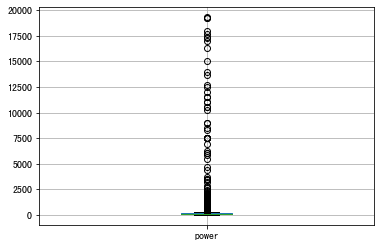

In [22]:
original_data.boxplot(['power'])

In [27]:
"""这里包装了一个异常值处理的代码，可以随便调用"""
def outliers_proc(data, col_name, scale=3):
    """
        用于截尾异常值， 默认用box_plot(scale=3)进行清洗
        param:
            data：接收pandas数据格式
            col_name: pandas列名
            scale: 尺度
    """
    data_col = data[col_name]
    Q1 = data_col.quantile(0.25) # 0.25分位数
    Q3 = data_col.quantile(0.75)  # 0,75分位数
    IQR = Q3 - Q1

    data_col[data_col < Q1 - (scale * IQR)] = Q1 - (scale * IQR)
    data_col[data_col > Q3 + (scale * IQR)] = Q3 + (scale * IQR)

    return data[col_name]


In [26]:
original_data['power'] = outliers_proc(original_data, 'power')

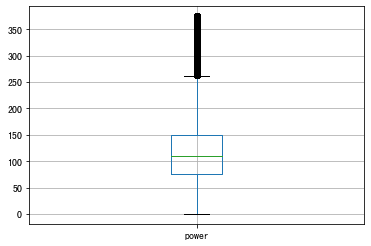

In [28]:
original_data.boxplot(['power'])

In [29]:
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())

    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

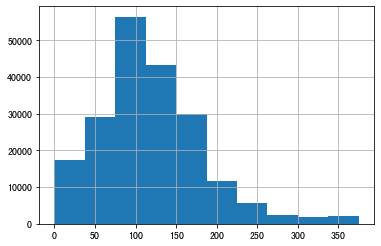

In [31]:
original_data['power'].hist()
#power这个特征的分布也不错了，所以就没再进一步处理power，至于其他的数值型是不是需要截尾

### 缺失值处理
关于缺失值处理的方式， 有几种情况：

不处理（这是针对xgboost等树模型），有些模型有处理缺失的机制，所以可以不处理

如果缺失的太多，可以考虑删除该列

插值补全（均值，中位数，众数，建模预测，多重插补等）

分箱处理，缺失值一个箱。

In [32]:
# # 删除重复值
# #data.drop_duplicates()
# # dropna()可以直接删除缺失样本，但是有点不太好

# # 填充固定值
# train_data.fillna(0, inplace=True) # 填充 0
# data.fillna({0:1000, 1:100, 2:0, 4:5})   # 可以使用字典的形式为不用列设定不同的填充值

# train_data.fillna(train_data.mean(),inplace=True) # 填充均值
# train_data.fillna(train_data.median(),inplace=True) # 填充中位数
# train_data.fillna(train_data.mode(),inplace=True) # 填充众数

# train_data.fillna(method='pad', inplace=True) # 填充前一条数据的值，但是前一条也不一定有值
# train_data.fillna(method='bfill', inplace=True) # 填充后一条数据的值，但是后一条也不一定有值

# """插值法：用插值法拟合出缺失的数据，然后进行填充。"""
# for f in features: 
#     train_data[f] = train_data[f].interpolate()

# train_data.dropna(inplace=True)

# """填充KNN数据：先利用knn计算临近的k个数据，然后填充他们的均值"""
# from fancyimpute import KNN
# train_data_x = pd.DataFrame(KNN(k=6).fit_transform(train_data_x), columns=features)

original_data.info()

### 数据分桶
连续值经常离散化或者分离成“箱子”进行分析, 为什么要做数据分桶呢？

离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；

离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰； 

LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；

离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；

特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化



当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性。现在介绍数据分桶的方式：

等频分桶

等距分桶

Best-KS分桶（类似利用基尼指数进行二分类）

卡方分桶

最好将数据分桶的特征作为新一列的特征，不要把原来的数据给替换掉, 所以在这里通过分桶的方式做一个特征出来看看，以power为例：

In [35]:
bin = [i*10 for i in range(31)]
original_data['power_bin'] = pd.cut(original_data['power'], bin, labels=False)

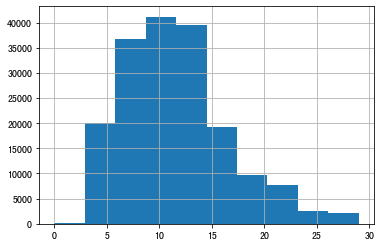

In [36]:
original_data['power_bin'].hist()

## 数据转换
数据转换的方式有：

数据归一化(MinMaxScaler)；

标准化(StandardScaler)；

对数变换(log1p)；

转换数据类型(astype)；

独热编码(OneHotEncoder)；

标签编码(LabelEncoder)；

修复偏斜特征(boxcox1p)等。

1. 数值特征归一化， 因为这里数值的取值范围相差很大

In [37]:
# minmax = MinMaxScaler()
# num_data_minmax = minmax.fit_transform(num_data)
# num_data_minmax = pd.DataFrame(num_data_minmax, columns=num_data.columns, index=num_data.index)

2. 类别特征独热一下

In [38]:
# """类别特征某些需要独热编码一下"""
# hot_features = ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage']
# cat_data_hot = pd.get_dummies(cat_data, columns=hot_features)

3. 关于高势集特征model，也就是类别中取值个数非常多的， 一般可以使用聚类的方式，然后独热，这里就采用了这种方式：

In [39]:
# from scipy.cluster.hierarchy import linkage, dendrogram
# #from sklearn.cluster import AgglomerativeClustering
# from sklearn.cluster import KMeans

# ac = KMeans(n_clusters=3)
# ac.fit(model_price_data)

# model_fea = ac.predict(model_price_data)
# plt.scatter(model_price_data[:,0], model_price_data[:,1], c=model_fea)

# cat_data_hot['model_fea'] = model_fea
# cat_data_hot = pd.get_dummies(cat_data_hot, columns=['model_fea'])

##  特征构造
在特征构造的时候，需要借助一些背景知识，遵循的一般原则就是需要发挥想象力，尽可能多的创造特征，不用先考虑哪些特征可能好，可能不好，先弥补这个广度。特征构造的时候需要考虑数值特征，类别特征，时间特征。

对于数值特征，一般会尝试一些它们之间的加减组合（当然不要乱来，根据特征表达的含义）或者提取一些统计特征

对于类别特征，我们一般会尝试之间的交叉组合，embedding也是一种思路

对于时间特征，这一块又可以作为一个大专题来学习，在时间序列的预测中这一块非常重要，也会非常复杂，需要就尽可能多的挖掘时间信息，会有不同的方式技巧。当然在这个比赛中涉及的实际序列数据有一点点，不会那么复杂。


![title](img/p2.png)

In [40]:
%%html
<img src='p2.png', width=500, height=400>

时间特征的构造(time_data)

根据上面的分析，可以构造的时间特征如下：

汽车的上线日期与汽车的注册日期之差就是汽车的使用时间，一般来说与价格成反比

对汽车的使用时间进行分箱，使用了3年以下，3-7年，7-10年和10年以上，分为四个等级， 10年之后就是报废车了，应该会影响价格

淡旺季也会影响价格，所以可以从汽车的上线日期上提取一下淡旺季信息



汽车的使用时间特征

createDate-regDate， 反应汽车使用时间，一般来说与价格成反比。但要注意的问题就是时间格式， regDateFalse这个字段有些是0月，如果忽略错误计算的话，使用时间有一些会是空值， 当然可以考虑删除这些空值，但是因为训练集和测试集合并了，那么就不轻易删除了。



本文采取的办法是把错误字段都给他加1个月，然后计算出天数之后在加上30天（这个有不同的处理方式， 但是一般不喜欢删除或者置为空，因为删除和空值都有潜在的副作用）

In [41]:
# 这里是为了标记一下哪些字段有错误
def regDateFalse(x):
    if str(x)[4:6] == '00':
        return 1
    else: 
        return 0
original_data['regDateFalse'] = original_data['regDate'].apply(lambda x: regDateFalse(x))
# 这里是改正错误字段
def changeFalse(x):
    x = str(x)
    if x[4:6] == '00':
        x = x[0:4] + '01' + x[6:]
        x = int(x)
    return x
original_data['regDate'] = original_data['regDate'].apply(lambda x: changeFalse(x))
# 使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
original_data['used_time'] = (pd.to_datetime(original_data['creatDate'], format='%Y%m%d') - 
                            pd.to_datetime(original_data['regDate'], format='%Y%m%d')).dt.days
# 修改错误
# 但是需要加上那一个月
original_data.loc[original_data.regDateFalse==1, 'used_time'] += 30
# 删除标记列
del original_data['regDateFalse']

一个特征构造完毕， used_time字段，表示汽车的使用时间

汽车是不是符合报废

时间特征还可以继续提取，我们假设用了10年的车作为报废车的话， 那么我们可以根据使用天数计算出年数， 然后根据年数构造出一个特征是不是报废

In [ ]:
# 使用时间换成年来表示
original_data['used_time'] = original_data['used_time'] / 365.0
original_data['Is_scrap'] = original_data['used_time'].apply(lambda x: 1 if x>=10 else 0)

In [44]:
bins = [0, 3, 7, 10, 20, 30]
original_data['estivalue'] = pd.cut(original_data['used_time'], bins, labels=False)

构造了两个时间特征。Is_scrap表示是否报废， estivalue表示使用时间的分箱。

是不是淡旺季

这个是根据汽车的上线售卖时间看， 每年的2， 3月份及6,7,8月份是整个汽车行业的低谷， 年初和年末及9月份是二手车销售的黄金时期， 所以根据上线时间选出淡旺季。

In [45]:
# 选出淡旺季
low_seasons = ['3', '6', '7', '8']
original_data['is_low_seasons'] = original_data['creatDate'].apply(lambda x: 1 if str(x)[5] in low_seasons else 0)

# 独热一下
original_data = pd.get_dummies(original_data, columns=['is_low_seasons'])

# 这样时间特征构造完毕，删除日期了
del original_data['regDate']
del original_data['creatDate']

根据汽车的使用时间或者淡旺季分桶进行统计特征的构造

类别特征的构造（cat_data）
经过上面的分析，可以构造的类别特征如下：

从邮编中提取城市信息， 因为是德国的数据，所以参考德国的邮编，加入先验知识， 但是感觉这个没有用，可以先试一下

最好是从regioncode中提取出是不是华东地区，因为华东地区是二手车交易的主要地区（这个没弄出来，不知道这些编码到底指的哪跟哪）

私用车和商用车分开（bodyType提取）

是不是微型车单独处理，所以感觉那些车的类型OneHot的时候有点分散了（bodyType这个提取，然后one-hot）

新能源车和燃油车分开（在fuelType中提取，然后进行OneHot）

地区编码还是有影响的， 不同的地区汽车的保率不同

品牌这块可以提取一些统计量， 统计特征的话上面这些新构造的特征其实也可以提取

注意，OneHot不要太早，否则有些特征就没法提取潜在信息了。



## 特征选择
特征选择(排序)对于数据科学家、机器学习从业者来说非常重要。好的特征选择能够提升模型的性能，更能帮助我们理解数据的特点、底层结构，这对进一步改善模型、算法都有着重要作用。



但是拿到数据集，一个特征选择方法，往往很难同时完成这两个目的。通常情况下，我们经常不管三七二十一，选择一种自己最熟悉或者最方便的特征选择方法（往往目的是降维，而忽略了对特征和数据理解的目的）, 但是真的好使吗？只能说具体问题具体分析，也许会暴力出奇迹呢。



特征选择主要有两个功能：

减少特征数量、降维，使模型泛化能力更强，减少过拟合

增强对特征和特征值之间的理解



通常来说，从两个方面考虑来选择特征：

特征是否发散：如果一个特征不发散，例如方差接近于0，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用。

特征与目标的相关性：这点比较显见，与目标相关性高的特征，应当优选选择。



根据特征选择的形式又可以将特征选择方法分为3种：

Filter：过滤法，按照发散性或者相关性对各个特征进行评分，设定阈值或者待选择阈值的个数，选择特征。

Wrapper：包装法，根据目标函数（通常是预测效果评分），每次选择若干特征，或者排除若干特征。

Embedded：嵌入法，先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据系数从大到小选择特征。类似于Filter方法，但是是通过训练来确定特征的优劣。



### 过滤式

主要思想: 对每一维特征“打分”，即给每一维的特征赋予权重，这样的权重就代表着该特征的重要性，然后依据权重排序。先进行特征选择，然后去训练学习器，所以特征选择的过程与学习器无关。相当于先对特征进行过滤操作，然后用特征子集来训练分类器。

主要方法：

移除低方差的特征；

相关系数排序，分别计算每个特征与输出值之间的相关系数，设定一个阈值，选择相关系数大于阈值的部分特征；

利用假设检验得到特征与输出值之间的相关性，方法有比如卡方检验、t检验、F检验等。

互信息，利用互信息从信息熵的角度分析相关性。



这里，本文为大家提供一些有价值的小tricks：

对于数值型特征，方差很小的特征可以不要，因为太小没有什么区分度，提供不了太多的信息，对于分类特征，也是同理，取值个数高度偏斜的那种可以先去掉。

根据与目标的相关性等选出比较相关的特征（当然有时候根据字段含义也可以选）

卡方检验一般是检查离散变量与离散变量的相关性，当然离散变量的相关性信息增益和信息增益比也是不错的选择（可以通过决策树模型来评估来看），person系数一般是查看连续变量与连续变量的线性相关关系。

### 去掉取值变化小的特征

这应该是最简单的特征选择方法了：假设某特征的特征值只有0和1，并且在所有输入样本中，95%的实例的该特征取值都是1，那就可以认为这个特征作用不大。如果100%都是1，那这个特征就没意义了。



当特征值都是离散型变量的时候这种方法才能用，如果是连续型变量，就需要将连续变量离散化之后才能用，而且实际当中，一般不太会有95%以上都取某个值的特征存在，所以这种方法虽然简单但是不太好用。



可以把它作为特征选择的预处理，先去掉那些取值变化小的特征，然后再从接下来提到的的特征选择方法中选择合适的进行进一步的特征选择。

### 单变量特征选择

单变量特征选择能够对每一个特征进行测试，衡量该特征和响应变量之间的关系，根据得分扔掉不好的特征。对于回归和分类问题可以采用卡方检验等方式对特征进行测试。



这种方法比较简单，易于运行，易于理解，通常对于理解数据有较好的效果（但对特征优化、提高泛化能力来说不一定有效）；这种方法有许多改进的版本、变种。



下面重点介绍一下pearson相关系数，皮尔森相关系数是一种最简单的，比较常用的方式。能帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性，结果的取值区间为[-1，1]，-1表示完全的负相关(这个变量下降，那个就会上升)，+1表示完全的正相关，0表示没有线性相关。



Pearson Correlation速度快、易于计算，经常在拿到数据(经过清洗和特征提取之后的)之后第一时间就执行。Scipy的pearsonr方法能够同时计算相关系数和p-value, 当然pandas的corr也可以计算。



直接根据pearson系数画出图像

In [47]:
# corr = original_data.corr('price')    # .corr('spearman')
# plt.figure(figsize=(25, 15))
# corr['price'].sort_values(ascending=False)[1:].plot(kind='bar')
# plt.tight_layout()

当然，这个数据用pearson系数可能不是那么合理，可以使用spearman系数，这个被认为是排列后的变量的pearson的相关系数， 具体的可以看(Pearson)皮尔逊相关系数和spearman相关系数, 这里只整理两者的区别和使用场景, 区别如下：

连续数据，正态分布，线性关系，用pearson相关系数是最恰当，当然用spearman相关系数也可以，效率没有pearson相关系数高。

上述任一条件不满足，就用spearman相关系数，不能用pearson相关系数。

两个定序测量数据（顺序变量）之间也用spearman相关系数，不能用pearson相关系数。

Pearson相关系数的一个明显缺陷是，作为特征排序机制，他只对线性关系敏感。如果关系是非线性的，即便两个变量具有一一对应的关系，Pearson相关性也可能会接近0。



当然还可以画出热力图来，这个不陌生了吧， 这个的目的是可以看变量之间的关系， 相关性大的，可以考虑保留其中一个：

从上面两个步骤中，就可以发现一些结论：

根据与price的线性相关关系来看的话，我们可以考虑正负相关0.6以上的特征， v_std, v_12, v_0, v_8, estivalue_price_average, estivalue_price_median, estivalue_price_std， kil_bin, kilmoeter, estivalue_count, used_time, estivalue, v_3

某些变量之间有很强的的关联性，比如v_mean和v_sum，这俩的相关性是1，所以可以删掉其中一个。

当然，依然是备选删除选项和备选保留选项（这些都先别做）， 因为我们有时候不能盲目，就比如上面的相关性，明明知道pearson的缺陷是无法捕捉非线性相关，所以得出的这个结论也是片面的结论。这些都是备选，先做个心中有数，后面再用一些别的方式看看再说（如果现在就删除了，后面的方法就不好判断了）



### 包裹式

单变量特征选择方法独立的衡量每个特征与响应变量之间的关系，另一种主流的特征选择方法是基于机器学习模型的方法。有些机器学习方法本身就具有对特征进行打分的机制，或者很容易将其运用到特征选择任务中，例如回归模型，SVM，决策树，随机森林等等。



主要思想：包裹式从初始特征集合中不断的选择特征子集，训练学习器，根据学习器的性能来对子集进行评价，直到选择出最佳的子集。包裹式特征选择直接针对给定学习器进行优化。

主要方法：递归特征消除算法, 基于机器学习模型的特征排序

优缺点：

优点：从最终学习器的性能来看，包裹式比过滤式更好；

缺点：由于特征选择过程中需要多次训练学习器，因此包裹式特征选择的计算开销通常比过滤式特征选择要大得多。



下面，这里整理基于学习模型的特征排序方法，这种方法的思路是直接使用你要用的机器学习算法，针对每个单独的特征和响应变量建立预测模型。其实Pearson相关系数等价于线性回归里的标准化回归系数。



假如某个特征和响应变量之间的关系是非线性的，可以用基于树的方法（决策树、随机森林）、或者扩展的线性模型等。基于树的方法比较易于使用，因为他们对非线性关系的建模比较好，并且不需要太多的调试。但要注意过拟合问题，因此树的深度最好不要太大，再就是运用交叉验证。



我们可以用随机森林来跑一下，看看随机森林比较喜欢特征：

In [ ]:

from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

X = select_data.iloc[:, :-1]
Y = select_data['price']
names = select_data.columns

rf = RandomForestRegressor(n_estimators=20, max_depth=4)
kfold = KFold(n_splits=5, shuffle=True, random_state=7)
scores = []
for column in X.columns:
    print(column)
    tempx = X[column].values.reshape(-1, 1)
    score = cross_val_score(rf, tempx, Y, scoring="r2",
                              cv=kfold)
    scores.append((round(np.mean(score), 3), column))
print(sorted(scores, reverse=True))

###  嵌入式

在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。而嵌入式特征选择在学习器 训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。



主要思想：在模型既定的情况下学习出对提高模型准确性最好的特征。也就是在确定模型的过程中，挑选出那些对模型的训练有重要意义的特征。

主要方法：简单易学的机器学习算法–岭回归（Ridge Regression），就是线性回归过程加入了L2正则项。



L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择



L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参 数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对于一个线性 回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移 得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』



这里简单介绍一下怎么使用，其实和上面机器学习模型的使用方法一样， 所以有时候这些方法没有必要严格的区分开：

### PCA降维技术
通过上面的特征选择部分，可以选出更好的分析特征，但是如果这些特征维度仍然很高怎么办？



如果数据特征维度太高，首先计算很麻烦，其次增加了问题的复杂程度，分析起来也不方便。这时候就会想是不是再去掉一些特征就好了呢？但是这个特征也不是凭自己的意愿去掉的，因为盲目减少数据的特征会损失掉数据包含的关键信息，容易产生错误的结论，对分析不利。



所以想找到一个合理的方式，既可以减少需要分析的指标，而且尽可能多的保持原来数据的信息，PCA就是这个合理的方式之一。 但要注意一点， 特征选择是从已存在的特征中选取携带信息最多的，选完之后的特征依然具有可解释性，而PCA，将已存在的特征压缩，降维完毕后不是原来特征的任何一个，也就是PCA降维之后的特征我们根本不知道什么含义了。

